In [7]:
import math
import numpy as np
from matplotlib import pyplot as plt
from pylab import meshgrid
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy import optimize
from scipy.integrate import quad

In [8]:
def R_abs(x, eSLA=20, h=10, lat=0,  day=17, R_inc=1367, alt = 0):
    
    LDMC = 0.4
    
    # Atmosferic loss corrections
    azz = 0.4237 - 0.00821*(6-alt)**2
    aoo = 0.5055 + 0.00595*(6.5-alt)**2
    kayy = 0.2711 + 0.01858*(2.5-alt)**2
    rz = 0.97
    ro = 0.99
    rk = 1.01
    az = azz*rz
    ao = aoo*ro
    kay = kayy*rk
    # Instantaneous corrected R_inc
    dec = np.radians(24.45*np.sin(2*np.pi*((284+day)/365))) # solar declination angle
    psi = np.arccos(np.cos(lat)*np.cos(dec)*np.cos(x) + np.sin(lat)*np.sin(dec)) # Solar zenith angle
    psi = np.where(psi < np.radians(96.07), psi, np.radians(96.07))
    Gon = R_inc*(1 + (1/30)*(np.cos((2*np.pi*day)/365)))
    am = 1/(np.cos(psi) + 0.50572*(96.07995-np.degrees(psi))**(-1.634)) # Air mass with curvature correction
    taub = az + ao*np.exp(-1*kay*am)
    
    In = Gon*taub # Clear sky beam irradiance
    
    # Scaling
    n = 2
    bet_lm = 0.16 # scaling coefficient for leaf mass from total biomass
    eta_lm = 0.779 #scaling exponent for leaf mass from total biomass
    bet_hm = 2.95
    eta_hm = 1.29
    bet_3 = 0.423
    bet_6 = 0.9
    bet_5 = 0.3524
    eta_5 = 1.14
    bet_mr = 0.421 # micro mol C/s*kg^eta_mr scaling coefficient for total plant respiration
    eta_mr = 0.78 # scaling exponent for total plant respiration
    
    M = eta_hm*h**(bet_hm)
    
    # Canopy geometry 
    r_can = bet_5*h**(eta_5) # Canopy radial extent in m
    h_can = bet_6*h # Canopy height in m
    zeta_dc = 0.06 # Deep canopy refelction coefficient
    zeta_s = 0.30 # Soil reflection coefficient
    alph = 0.5 # leaf absorptivity
    
    # Canopy projections
    theta = np.arctan(-h_can/(2*r_can*np.tan(psi)))
    P_can = np.pi*r_can*(r_can*np.cos(theta) + 0.5*h_can*np.sin(theta)*np.tan(-psi))
    S_arc = np.arcsin(2*np.sqrt(abs((0.5*h_can)**(2) - r_can**(2)))/h_can)
    S_can = 2*np.pi*(r_can**(2) + (r_can**(2)*(h_can*0.5)**(2))*S_arc/(np.sqrt(abs((0.5*h_can)**(2) - r_can**(2)))))
    K = 2*P_can/S_can
    
    LAI = (bet_lm*M**(eta_lm))*eSLA*LDMC/(math.pi*r_can**(2)) # Leaf area index
    f = (zeta_dc-zeta_s)/(zeta_dc*zeta_s - 1) 
    zeta_c = (zeta_dc + f*np.exp(-2*K*LAI))/(1 + zeta_dc*f*np.exp(-2*K*LAI)) # Canopy reflectance
    tau = np.exp(-np.sqrt(alph)*K*LAI) # Canopy transmission ceofficient
    alph_can = 1 - zeta_c - (1-zeta_s)*tau # Total solar radiaition absorption coefficient for canopy
    R_abs = alph_can*P_can*In #Total solar radiation absorbed by canopy (Watts)
    I_c = (1-zeta_c)*(1-np.exp(-K*LAI)) # PAR absorption coefficient for canopy 
    I_abs = I_c*P_can*In #Total PAR absorbed by canopy (Watts)
    
    return R_abs, I_abs, In

In [11]:
def G_de_v2(eSLA, T_A = 20, p_a = 101.3, h=10, p_inc=0.940, uw=4, RH=50, 
            lat=0, alt=0, gsday0=180, gsl=90):
    LDMC = 0.4
    f_g = gsl/365
    
    T_D = T_A - (100-RH)/5
    
    #constants
    JtoMol = 4.6*10**(-6)
    fPAR = 0.5
    mu_w = 0.01801528 # kg/mol
    rho_w = 998 # kg/m^{3}
    gamma = 1/3 # WUE
    D_H = 18.46*10**(-6) # Thermal heat diffusivity of air (m^{2}/s)
    D_nu = 24.9*10**(-6) # Thermal heat diffusivity of water in air (m^{2}/s)
    nu_a = 1.52*10**(-5) # kinematic viscosity of air (m^2/s) at 20C
    S_ca = nu_a/D_nu # Dimensionless Schmidt number 
    P_ra = nu_a/D_H # Dimensionless Prandtl number for air
    c_p = 29.10 # Specific heat of air (isobaric) (J/mol K)
    sig = 5.67*10**(-8) # Stefan-Boltzmann Constant (W/m^2K^4)
    C_c = 23
    
    # Scaling
    n = 2
    bet_lm = 0.16 # scaling coefficient for leaf mass from total biomass
    eta_lm = 0.779 #scaling exponent for leaf mass from total biomass
    bet_hm = 2.95
    eta_hm = 1.29
    bet_3 = 0.423
    bet_6 = 0.9
    bet_5 = 0.3524
    eta_5 = 1.14
    bet_mr = 0.421 # micro mol C/s*kg^eta_mr scaling coefficient for total plant respiration
    eta_mr = 0.78 # scaling exponent for total plant respiration
    
    M = eta_hm*h**(bet_hm)
    # 
    delta_s = 220 #stomatal density stomata/mm^2
    a_s = 235.1*10**(-6) # stomatal area mm^2
    z_s = 10*10**(-6) # stomatal depth m
    eps_l = 0.95# leaf emissivity ()
    b_1 = 0.611 # KPa
    b_2 = 17.502 # Dimensionless
    b_3 = 240.97 # deg C
    lamb = 40660 # latent heat of water evaporation (J/mol)
    
    a_L = bet_lm*M**(eta_lm)*eSLA*LDMC
    rN = 0.44*10**(-3)
    r0 = 2.47*(M)**(0.382)/200
    N = 2*np.log(r0/rN)/np.log(n)
    nN = n**N
    
    # Environmental dependencies of leaf conductance
    rho_a = (44.6*p_a*273.15)/(101.3*(T_A+273)) # molar density of air (mol/m^3)
    d = 1.62*np.sqrt(a_L/(nN*np.pi))
    R_ea = uw*d/nu_a
    e_a = b_1*np.exp(b_2*T_A/(b_3+T_A))
    de_a = (b_1*b_2*b_3/(b_3+T_A)**(2))*np.exp(b_2*T_A/(b_3+T_A))
    D_v = b_1*np.exp(b_2*T_A/(b_3+T_A)) - b_1*np.exp(b_2*T_D/(b_3+T_D))
    
    # Conductances
    g_ua = (0.664*rho_a*D_v*(R_ea**(1/2))*(S_ca**(1/3)))/d
    g_us = rho_a*D_nu/z_s
    g_ul = g_us*a_s*delta_s
    g_ups = 1/((1/g_ul) + (1/g_ua))
    g_Ha = (0.664*rho_a*D_H*(R_ea**(1/2))*(P_ra**(1/3)))/d
    g_r = 4*eps_l*sig*(T_A+273)**(3)/c_p # Radiative conductance
    
    
    # Flux coefficients
    g_1 = eps_l*sig*(T_A+273)**(4)
    g_2 = g_r*c_p
    j_1 = c_p*g_Ha
    f_1 = lamb*g_ups*de_a/p_a
    f_2 = lamb*g_ups*D_v/p_a
    
    # Areas
    a_f = 2*a_L*delta_s*a_s
    a_g = a_L
    a_j = 2*a_L

    # Canopy geomery 
    r_can = bet_5*h**(eta_5) # Canopy radial extent in m
    h_can = bet_6*h # Canopy height in m
    zeta_dc = 0.06 # Deep canopy refelction coefficient
    zeta_s = 0.27 # Soil reflection coefficient
    alph = 0.5 # leaf absorptivity
    
    R_avg = 0
    I_tot = 0
    step = math.floor(gsl/3)
    for i in range(int(gsday0), int(gsday0 + gsl), step):
        day = ((i-1) % 365) + 1
        dec = np.radians(24.45*np.sin(np.radians(360*((284+day)/365)))) # solar declination angle
        sol_set = np.arccos(-np.tan(lat)*np.tan(dec)) # sunrise and sunset times
        R = lambda x:R_abs(x, eSLA=eSLA, h=h,  day=day, lat=lat, R_inc=1367)[0]
        I = lambda x:R_abs(x, eSLA=eSLA, h=h,  day=day, lat=lat, R_inc=1367)[1] 
        # We integrate R_abs and I_abs over a diurnal cycle and average over day length to get average R_abs
        R_temp = quad(R, -sol_set, sol_set)
        I_temp = quad(I, -sol_set, sol_set)
        R_avg += (R_temp[0])/(2*np.pi*5) # Average solar irradiance in Watts
        I_tot += (3600*I_temp[0])/(5*0.2618) # Averaged over growing season length and multiplied by a
        # factor of 3600 (hours to seconds) and divided by 0.2618 (solar hour angle in Rad to hours) to render Joules
    
    # Hydraulic traits
    r_roo = bet_3**(1/4)*h
    pre_s = p_inc/(3600*24*gsl) #convert incoming precipitation into m/season to m/s
    Q_p = gamma*(math.pi*r_roo**2)*pre_s
    E = (f_1/lamb)*((R_avg - a_f*f_2 - a_g*g_2)/(f_1*a_f + g_1*a_g + j_1*a_j)) + f_2/lamb
    Q_e = (mu_w/rho_w)*a_f*E
    
    # Leaf photosynthesis
    u = 768 # Dimensionless +- 71
    k1 = 0.030 # Scaling factor (Kg of biomass/molC)
    k2 = 0.0864 # Scaling factor (s*molC/day*micromolC) = (molC/day)/(micromolC/s)
    Kc_25 = 0.03997 # kPa
    E_aKc = 79430 # J/mol
    Ko_25 = 27.480 # kPa
    E_aKo = 36380 # J/mol
    po2 = 0.2095*p_a
    c_a = 0.0004*p_a
    T_K = T_A + 273.15
    k_b = 8.314 #J/K*mol
    a_l = 0.8 #leaf absorptance
    b_l = 0.010875# fraction of a_l that reaches photsystem II
    T_crt = 647.096 # Critical temperature of water at sea level K
    H0 = 1.677
    H1 = 2.204
    H2 = 0.636
    H3 = -0.241
    
    def arrh(T_C, E_a):
        T_K = T_C + 273.15
        k_b = 8.314 #J/K*mol
        return np.exp(-E_a/(k_b*T_K))/np.exp(-E_a/(k_b*273.15))

    def hT(T_C):
        T_K = T_C + 273.15
        k_b = 8.314 #J/K*mol
        a_s = 668.39 #K*mol
        b_s = 1.07 # J/mol K^2
        dS = a_s - b_s*T_K
        H_d = 200000 # J/mol
        H_v = 71513 # J/mol
        farrh = np.exp(-H_v/(k_b*T_K))/np.exp(-H_v/(k_b*273.15))
        mod = (1+np.exp((273.15*dS - H_d)/(k_b*273.15)))/(1+np.exp((T_K*dS - H_d)/(k_b*T_K)))
        return farrh*mod


    Kc = Kc_25*arrh(T_C=T_A, E_a=E_aKc)
    Ko = Ko_25*arrh(T_C=T_A, E_a=E_aKo)
    K_s = Kc*(1+(po2/Ko)) # Effective Michaelis-Menten Coefficient
    beta_carb = 146 # ratio of unit costs for the maintenance of carboxylation and water transport capacities at 25C

    eta_s = 100*np.sqrt(T_K/T_crt)/(H0 + H1*(T_crt/T_K) + H2*(T_crt/T_K)**2 + H3*(T_crt/T_K)**3) # viscosity of water depends on temp
    phi_0 = 0.08718*(0.352 + 0.022*T_A - 0.00034*T_A**2)# intrinsic quantum efficiency of photosynthesis (dep T)
    I_abs = I_tot*fPAR*JtoMol # Leaf absorbed PPFD micromols per day
    gam_s = po2*np.exp(6.779 - 37830/(T_K*k_b)) # Photorespiratory compensation point (depT)

    zet = np.sqrt(beta_carb*(gam_s+K_s)/(1.6*eta_s))
    c_i = (zet*c_a +gam_s*np.sqrt(D_v))/(zet + np.sqrt(D_v)) # Leaf internal partial pressure of CO2
    m = (c_i - gam_s)/(c_i + 2*gam_s)
    m_c = (c_i - gam_s)/(c_i + K_s)
    Vcmax_gt = phi_0*I_abs*m/m_c
    Vcmax_25 = Vcmax_gt/hT(T_C=T_A)
    A_0 = k1*Vcmax_gt*m_c
    
    B_0 = bet_mr*M**(eta_mr)*k1*k2
    gamma0 = A_0*f_g
    gamma1 = (A_0*f_g**(2))*365*k1*k2*Vcmax_25/(2*u)
    
    Q_r = Q_p/Q_e

    G_0 = (gamma0 - gamma1/(1000/eSLA))
    
    return G_0, Q_r, B_0

In [4]:
import pandas as pd

data = pd.read_csv("NEON_full.csv")

In [5]:
var_list = ['plotID', 'latitude', 'CHELSA_gsl_1981.2010_V.2.1', 'CHELSA_fgd_1981.2010_V.2.1',
           'CHELSA_gsp_1981.2010_V.2.1', 'CHELSA_gst_1981.2010_V.2.1', 'gshurs', 'gs_sfcWind',
           'gedi_rh90_1000m', 'mean', 'n']
mod_data = data[var_list]
mod_data.dropna(inplace=True)


C:\Users\micho\AppData\Local\Temp\ipykernel_24808\468568375.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod_data.dropna(inplace=True)


In [15]:
bet_hm = 2.58
eta_hm = 0.264
M = 1.29*h**(2.95)
h = (M/1.29)**(1/2.95)
h1 = eta_hm*M**bet_hm
h, h1

(4.369966063374516, 38159.6099476925)

In [12]:
varNames = ['G0', 'Qr', 'B0']
response = pd.DataFrame(columns=varNames)
for idx, row in mod_data.iterrows():
    h = row['gedi_rh90_1000m']
    lat = np.radians(row['latitude'])
    gsl = row['CHELSA_gsl_1981.2010_V.2.1']
    fdg = row['CHELSA_fgd_1981.2010_V.2.1']
    sfcWind = row['gs_sfcWind']
    hurs = row['gshurs']
    temp = row['CHELSA_gst_1981.2010_V.2.1']
    precip = row['CHELSA_gsp_1981.2010_V.2.1']/1000
    eLMA = row['mean']*10000
    eSLA = 1000/(eLMA)
    
    res = G_de_v2(eSLA=eSLA, T_A=temp, h=h, p_inc=precip, uw=sfcWind, RH=hurs, 
            lat=lat, gsday0=fdg, gsl=gsl)
    G0 = res[0]
    Qr = res[1]
    B0 = res[2]
    nu = 0.6
    k = 3.2
    G = ((1/(1+np.exp(-nu*(Qr-k))))*G0 - B0)
    response.loc[idx] = (G0, Qr, B0)
    print(Qr, eSLA)
    
    
    



0.23996274420826852 8.954504312668368
0.19471820819819577 10.507618864286117
0.23237925412496513 10.52861684639235
0.3424621560635022 6.260282709984985
0.2468892572181605 9.864844478630516
0.4776124473563344 4.444730191209849
0.20653693768862003 10.414563955355575
0.20300101024176198 10.076325647699916
0.551036795676238 4.382570630549142
0.19817086828686437 12.371438715124643
0.23193278886873692 9.266677964291553
0.22122966755044965 9.718176052873874
0.27545342813252693 8.863611641210484
0.20642598230514408 10.420199765649707
0.2299380321592048 8.889315378486716
0.23346599238712512 8.754214059793034
0.23285066051812514 10.507034275574398
0.1967048032511534 10.859462965892002
0.27346146266416965 7.46722011710916
0.2483699940583068 9.842552380525872
0.20628690534434294 11.878474416646636
0.22514571081906587 10.871244056521011
0.3122780736797722 6.869193738860422
0.20051721472617184 10.7294942934514
0.1949316987916708 11.039189259862377
0.2162723399227109 9.869163512399766
0.2683253578950

In [67]:
def loss(nu, k, G0, Qr, B0):
    z = 0
    z += ((1/(1+np.exp(-nu*(Qr-k))))*G0 - B0)**2
    return z

loss_vect = np.vectorize(loss)

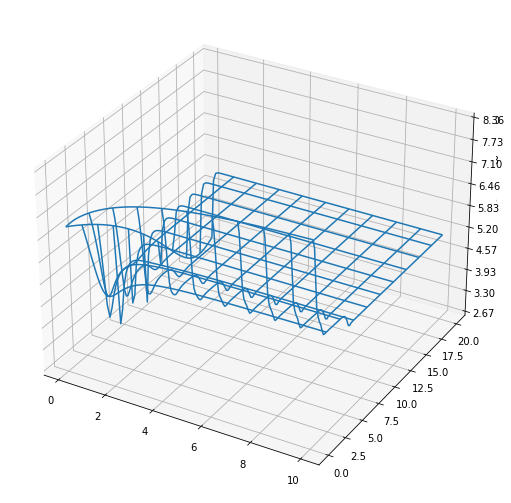

In [70]:
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

x = np.linspace(0.1, 10, 100)
y = np.linspace(0.1, 20, 100)
X, Y = meshgrid(x, y)
z=[0]*100

for idx, row in response.iterrows():
    G0 = row['G0']
    B0 = row['B0']
    Qr = row['Qr']
    
    z += loss_vect(nu=X, k=Y, G0=G0, Qr=Qr, B0=B0)


ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, np.log(z), rstride=10, cstride=10)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

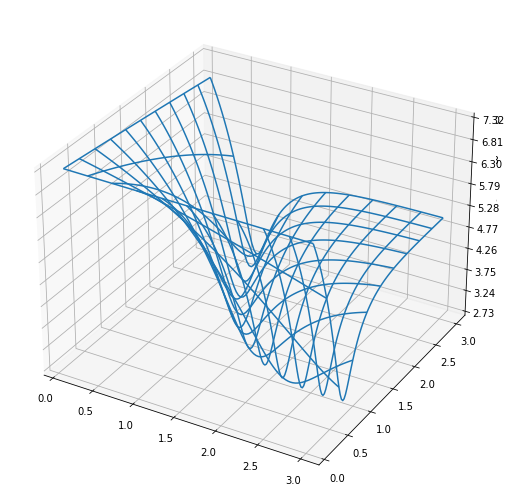

In [77]:
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, np.log(z), rstride=10, cstride=10)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

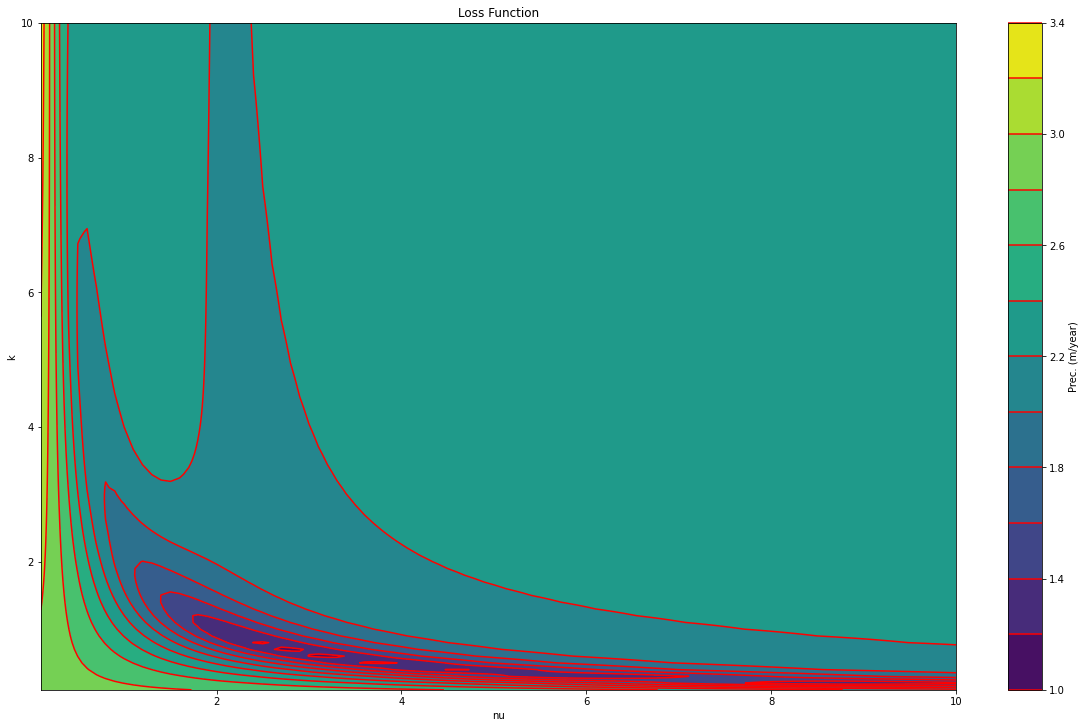

In [53]:
fig1, ax2 = plt.subplots(layout='constrained', figsize=(15,10))

CS = ax2.contourf(Y, X, np.log10(z), 10, cmap="viridis")

# Note that in the following, we explicitly pass in a subset of the contour
# levels used for the filled contours.  Alternatively, we could pass in
# additional levels to provide extra resolution, or leave out the *levels*
# keyword argument to use all of the original levels.

CS2 = ax2.contour(CS, levels=CS.levels[::1], colors='r')

ax2.set_title('Loss Function')
ax2.set_xlabel('nu')
ax2.set_ylabel('k')

# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('Prec. (m/year)')
# Add the contour line levels to the colorbar
cbar.add_lines(CS2)
plt.savefig("SLA_G_Pinc.png", bbox_inches='tight', dpi=300)

In [55]:
G_de_v2(eSLA=20, h=10, p_inc=2)

(0.8590262472044619, 0.7298316984856315, 0.26618100904838393)

In [71]:
i = np.where(z == z.min())

X[i], Y[i], z[i]




(array([0.2]), array([9.54747475]), array([14.45000491]))

In [56]:
def loss2(k, G0, Qr, B0):
    z = 0
    z += (((Qr - k)/Qr)*G0 - B0)**2
    return z

loss2_vect = np.vectorize(loss2)

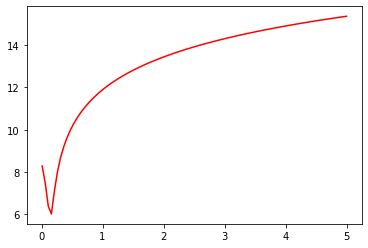

In [59]:
G_vect = np.vectorize(G_de_v2)
x = np.linspace(0.01, 5, 100)
y=[0]*100
for idx, row in response.iterrows():
    G0 = row['G0']
    B0 = row['B0']
    Qr = row['Qr']
    
    y += loss2_vect(k=x, G0=G0, Qr=Qr, B0=B0)


plot = plt.plot(x, np.log(y), color='red')

plt.show(plot)

In [58]:
i = np.where(y == y.min())

x[i], y[i]



(array([0.14434343]), array([360.2789353]))